# LungEpitelium_NEr-fAOs_MergedDatasets

## Imports

In [1]:
import scvelo as scv
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import os, tqdm
import harmonypy as hm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import seaborn.objects as so
import scanpy.external as sce
from scipy.sparse import coo_matrix
from bioinfokit import analys, visuz
from sanbomics.plots import volcano
from scipy.cluster import hierarchy
from adjustText import adjust_text
import leidenalg
import gseapy as gp
from gseapy import barplot, dotplot
import decoupler
from scipy import io
import tempfile
import celltypist
from celltypist import models
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker
import scBalance.scbalance_IO as ss
import scBalance as sb
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
from scipy.sparse import csr_matrix
import scipy.sparse as sp

## Figure Settings

In [2]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './../figures/'
scv.settings.figdir = './../figures/'
figfolder = './../figures/'


# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

### Custom colormap

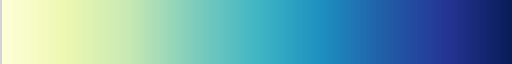

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## PCA AND EMBEDDINGS WITHOUT INTEGRATION

In [4]:
#Load adata before harmony integration
adata = sc.read_h5ad('./../data/MergedDatasets/Merged_LungEpithelium_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'Technique_colors', 'annotation_colors', 'hvg', 'log1p', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    varm: 'PCs'
    layers: 'counts', 'scaled'

In [5]:
category_counts = adata.obs['Reference'].value_counts()
category_counts

Guo et al., (2023)              43238
Goldfarbmuren et al., (2020)    27395
Reyfman et al., (2019)          20099
Deprez et al., (2020)           13720
Conchola et al., (2023)         10614
Melms et al., (2021)             9406
Travaglini et al., (2020)        8058
Habermann et al., (2019)         7447
Adams et al., (2020)             6500
Candeli et al., (2025)           5441
Name: Reference, dtype: int64

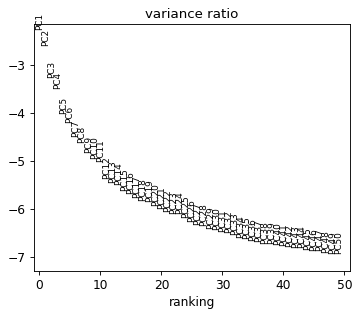

In [6]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

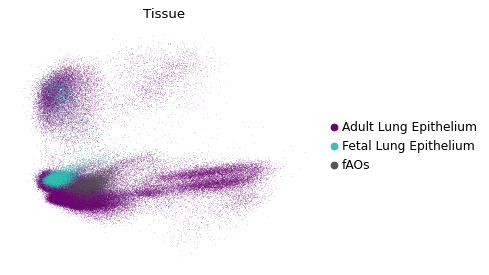

In [7]:
adata.uns['Tissue_colors']=['#6A0572','#2EC4B6','#555555']
sc.pl.pca_scatter(adata, color=['Tissue'])

2026-01-09 17:43:30.846590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-09 17:43:30.846674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-09 17:43:31.393231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2026-01-09 17:43:44.091004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


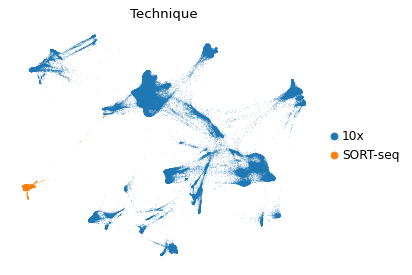

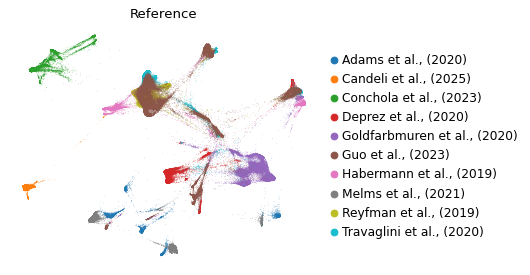

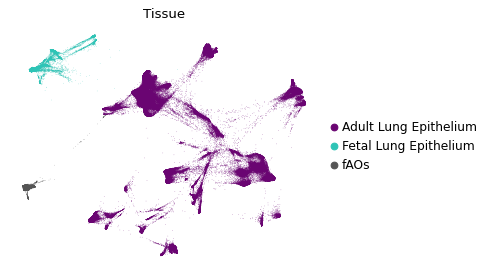

In [8]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color= 'Technique')
sc.pl.draw_graph(adata, color= 'Reference')
sc.pl.draw_graph(adata, color= 'Tissue')

## HARMONY INTEGRATION

In [9]:
sc.external.pp.harmony_integrate(adata, ['Technique', 'Sample ID'], basis= 'X_pca', adjusted_basis= 'X_pca_harmony')

2026-01-09 18:08:59,609 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


2026-01-09 18:09:33,699 - harmonypy - INFO - sklearn.KMeans initialization complete.


INFO:harmonypy:sklearn.KMeans initialization complete.


2026-01-09 18:09:34,249 - harmonypy - INFO - Iteration 1 of 50


INFO:harmonypy:Iteration 1 of 50


2026-01-09 18:11:37,534 - harmonypy - INFO - Iteration 2 of 50


INFO:harmonypy:Iteration 2 of 50


2026-01-09 18:13:41,024 - harmonypy - INFO - Iteration 3 of 50


INFO:harmonypy:Iteration 3 of 50


2026-01-09 18:15:44,275 - harmonypy - INFO - Iteration 4 of 50


INFO:harmonypy:Iteration 4 of 50


2026-01-09 18:17:47,743 - harmonypy - INFO - Iteration 5 of 50


INFO:harmonypy:Iteration 5 of 50


2026-01-09 18:19:51,019 - harmonypy - INFO - Iteration 6 of 50


INFO:harmonypy:Iteration 6 of 50


2026-01-09 18:21:54,504 - harmonypy - INFO - Iteration 7 of 50


INFO:harmonypy:Iteration 7 of 50


2026-01-09 18:23:57,821 - harmonypy - INFO - Iteration 8 of 50


INFO:harmonypy:Iteration 8 of 50


2026-01-09 18:26:01,286 - harmonypy - INFO - Converged after 8 iterations


INFO:harmonypy:Converged after 8 iterations


In [10]:
adata.obsm['prev_X_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

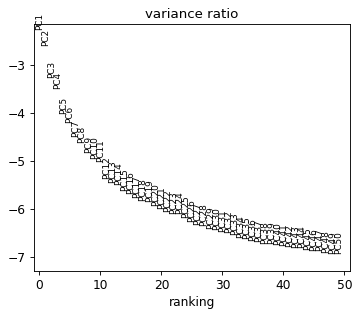

In [11]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

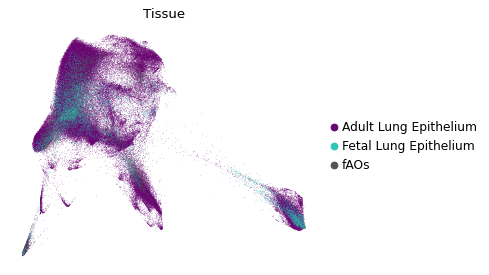

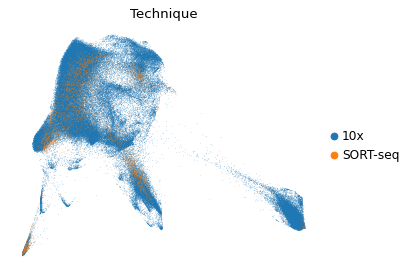

In [12]:
# Compute neighbors, leiden clusters, and UMAP
sc.pp.neighbors(adata, n_neighbors= 30, n_pcs= 25)
sc.tl.leiden(adata,resolution=1)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color=['Tissue'])
sc.pl.draw_graph(adata, color=['Technique'])

In [13]:
adata.write_h5ad(
    './../data/MergedDatasets/Merged_LungEpithelium_batch_corrected.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## Figure 3B

In [4]:
adata = sc.read_h5ad('./../data/MergedDatasets/Merged_LungEpithelium_batch_corrected.h5ad')
adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'Technique_colors', 'Tissue_colors', 'annotation_colors', 'draw_graph', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs['Tissue']

Donor27_Donor27_AAACGAACACCGTGCA-1    Adult Lung Epithelium
Donor27_Donor27_AAAGAACAGCGCCATC-1    Adult Lung Epithelium
Donor27_Donor27_AAAGAACCAGGCAATG-1    Adult Lung Epithelium
Donor27_Donor27_AAAGTGACACGGCCAT-1    Adult Lung Epithelium
Donor27_Donor27_AAATGGACAAAGGAGA-1    Adult Lung Epithelium
                                              ...          
s007.152                                               fAOs
s007.154                                               fAOs
s007.155                                               fAOs
s007.156                                               fAOs
s007.157                                               fAOs
Name: Tissue, Length: 151918, dtype: category
Categories (3, object): ['Adult Lung Epithelium', 'Fetal Lung Epithelium', 'fAOs']

In [6]:
adata.obs['Tissue_AOs_media'] = ''

for i in adata.obs.index:
    if adata.obs.loc[i, 'Tissue'] == 'fAOs':
        adata.obs.loc[i, 'Tissue_AOs_media'] = 'fAOs (' + adata.obs.loc[i, 'Media'] + ')'
    else :
        adata.obs.loc[i, 'Tissue_AOs_media'] = adata.obs.loc[i, 'Tissue']

sorted_categories=['Adult Lung Epithelium','Fetal Lung Epithelium',
                   'fAOs (Standard)','fAOs (NE Expansion)','fAOs (NE Differentiation)']
adata.obs['Tissue_AOs_media'] = pd.Categorical(adata.obs['Tissue_AOs_media'], categories=sorted_categories)

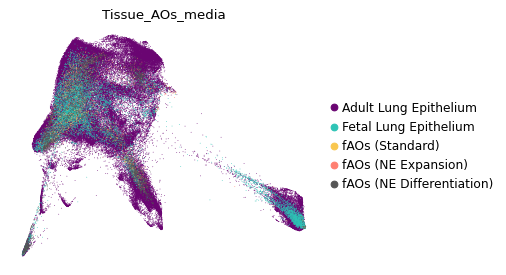

In [7]:
adata.uns['Tissue_AOs_media_colors']=['#6A0572','#2EC4B6','#F9C74F','#FF7F71','#555555']
sc.pl.draw_graph(adata, color=['Tissue_AOs_media'], 
                 size=2,
                 save='_Alignment_Lung_Epithelium_harmonized_tissue_AOs_media')

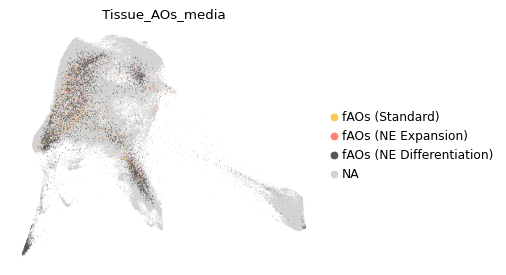

In [8]:
# Figure 3B
adata.uns['Tissue_AOs_media_colors']=['#6A0572','#2EC4B6','#F9C74F','#FF7F71','#555555']
sc.pl.draw_graph(adata, color=['Tissue_AOs_media'],
                 groups=['fAOs (Standard)','fAOs (NE Expansion)','fAOs (NE Differentiation)'],
                 size=2,
                 save='_Alignment_Lung_Epithelium_harmonized_tissue_only_AOs_media')

## Figure S3D

In [9]:
unique_annotations = adata.obs['annotation'].cat.categories
print(unique_annotations)

Index(['AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor',
       'Ciliated', 'Club-like Secretory', 'Deuterosomal', 'Goblet',
       'Goblet-like Secretory', 'Ionocyte', 'LAP', 'MEC', 'Mucous',
       'Multiciliated', 'Multiciliated Precursor', 'PNEC', 'RAS',
       'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft',
       'Unknown'],
      dtype='object')

In [10]:
# Rename categories
adata.obs['annotation'] = adata.obs['annotation'].replace({
    'Ciliated': 'Multiciliated',
    'Multiciliated Precursor': 'Multiciliated'
})

In [11]:
adata.obs['annotation'] = adata.obs['annotation'].astype(str)
adata.obs['annotation'].replace('nan', 'fAOs', inplace=True)

In [12]:
category_counts = adata.obs['annotation'].value_counts()
category_counts

AT2                      59053
Suprabasal               20167
Multiciliated            15365
Basal                    13996
AT1                      12039
fAOs                      5441
Serous                    4333
RAS                       4257
Secretory                 2699
Goblet                    2521
LAP                       2245
Bud Tip Progenitor        1776
Bud Tip Adjacent          1626
PNEC                      1577
Mucous                    1113
SMG Basal/Duct            1009
Club-like Secretory        845
Goblet-like Secretory      715
MEC                        669
Deuterosomal               202
Ionocyte                   159
Tuft                        88
Unknown                     23
Name: annotation, dtype: int64

In [13]:
sorted_categories = category_counts.index.to_list()
sorted_categories

['AT2',
 'Suprabasal',
 'Multiciliated',
 'Basal',
 'AT1',
 'fAOs',
 'Serous',
 'RAS',
 'Secretory',
 'Goblet',
 'LAP',
 'Bud Tip Progenitor',
 'Bud Tip Adjacent',
 'PNEC',
 'Mucous',
 'SMG Basal/Duct',
 'Club-like Secretory',
 'Goblet-like Secretory',
 'MEC',
 'Deuterosomal',
 'Ionocyte',
 'Tuft',
 'Unknown']

In [14]:
category_counts = adata.obs['annotation'].value_counts()
sorted_categories = category_counts.index.to_list()
adata.obs['annotation'] = pd.Categorical(adata.obs['annotation'], categories=sorted_categories, ordered=True)

In [15]:
adata.uns['annotation_colors'] = [
    '#a6cee3',  # AT2
    '#cab2d6', # Suprabasal
    '#e377c2',  # Multiciliated
    '#1f78b4',  # Basal
    '#e31a1c',  # AT1
    '#555555',  # fAOs
    '#fdbf6f',  # Serous
    '#ff7f00',  # RAS
    '#33a02c',  # Secretory
    '#b15928',  # Goblet
    '#ffff99',  # LAP
    '#6a3d9a',  # Bud Tip Progenitor
    '#17becf',  # Bud Tip Adjacent 
    '#9467bd',  # PNEC
    '#8c564b',  # Mucous
    '#7f7f7f',  # SMG Basal/Duct
    '#bcbd22',  # Club-like Secretory
    '#b2df8a',  # Goblet-like Secretory
    '#98df8a',  # MEC
    '#aec7e8',  # Deuterosomal
    '#c7c7c7',  # Ionocyte
    '#9edae5',  # Tuft
    '#fb9a99',  # Unknown
]

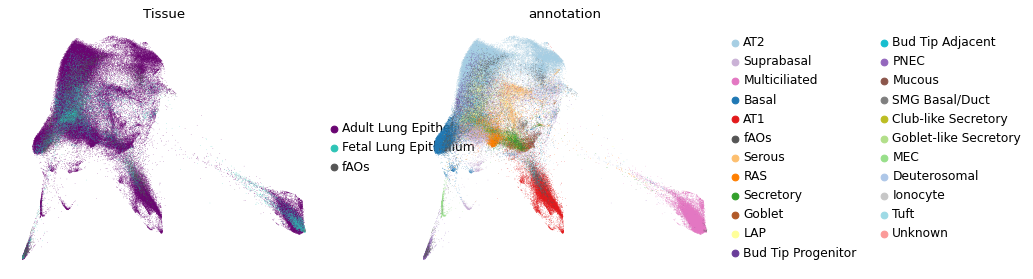

In [16]:
adata.uns['Tissue_colors']=['#6A0572','#2EC4B6','#555555']
sc.pl.draw_graph(adata, color=['Tissue','annotation'])

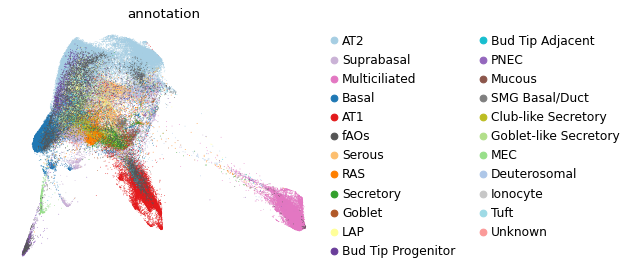

In [17]:
# Figure S3B
sc.pl.draw_graph(adata, color=['annotation'],size=2, save='_Alignment_Lung_Epithelium_annotation_labels')

## Figure 3C

In [18]:
adata_NEr_fAOs = sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata_NEr_fAOs

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

In [19]:
adata_NEr_fAOs.obs['CELL_TYPE']=adata_NEr_fAOs.obs['CELLTYPIST']

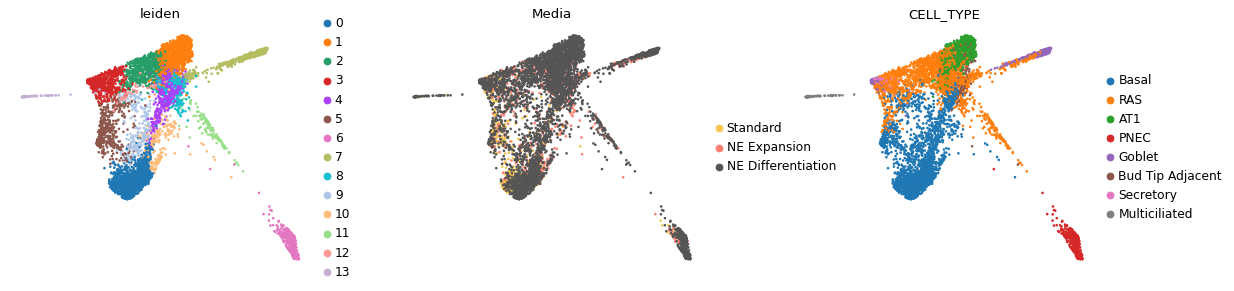

In [20]:
sc.pl.draw_graph(adata_NEr_fAOs, color=['leiden','Media','CELL_TYPE'])

In [21]:
adata.obs['CELL_TYPE_tissue'] = ''

for i in adata.obs.index:
    if adata.obs.loc[i, 'Tissue'] == 'fAOs':
        adata.obs.loc[i, 'CELL_TYPE_tissue'] = adata_NEr_fAOs.obs.loc[i, 'CELL_TYPE'] + ' (fAOs)' 
    elif adata.obs.loc[i, 'Tissue'] == 'Adult Lung Epithelium':
        adata.obs.loc[i, 'CELL_TYPE_tissue'] = adata.obs.loc[i, 'annotation'] + ' (Adult)'
    elif adata.obs.loc[i, 'Tissue'] == 'Fetal Lung Epithelium':
        adata.obs.loc[i, 'CELL_TYPE_tissue'] = adata.obs.loc[i, 'annotation'] + ' (Fetal)'

... storing 'CELL_TYPE_tissue' as categorical


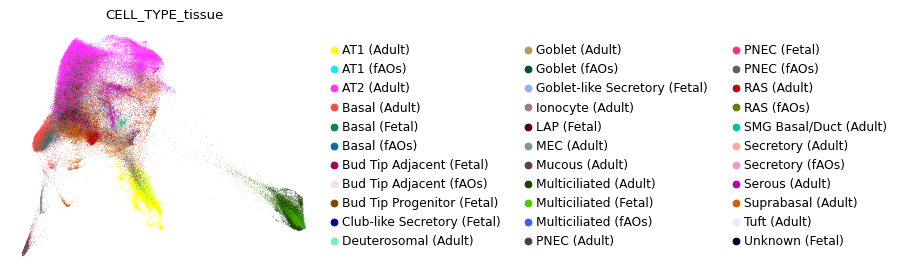

In [22]:
sc.pl.draw_graph(adata, color=['CELL_TYPE_tissue'])

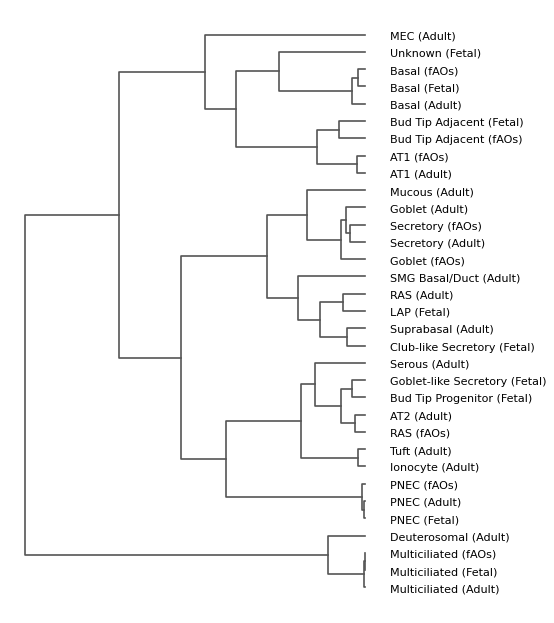

In [23]:
# Figure 3C
sc.tl.dendrogram(adata,groupby='CELL_TYPE_tissue',n_pcs=25,cor_method='pearson',optimal_ordering=True)
plt.figure(figsize=(6, 10))
ax = plt.gca()
sc.pl.dendrogram(adata, groupby='CELL_TYPE_tissue', ax=ax,orientation='left',save='_Alignment_Lung_Epithelium_annotation_CELL_TYPE_tissue')
plt.show()

## Figure S3G

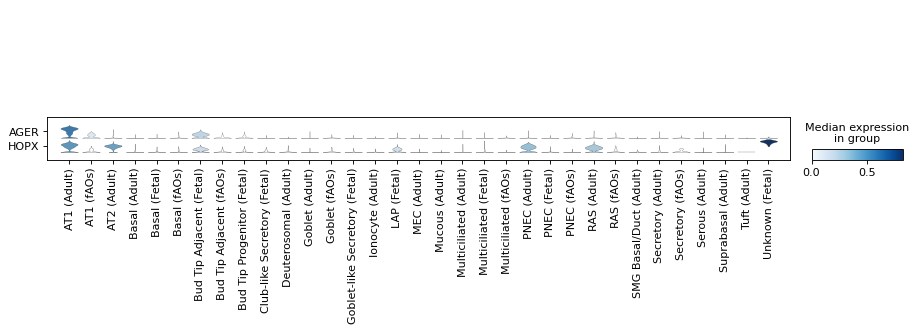

In [34]:
#AT1 Markers
AT1_markers=['AGER', 'HOPX']
sc.tl.score_genes(adata, AT1_markers, score_name='Alveolar Type 1_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,AT1_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

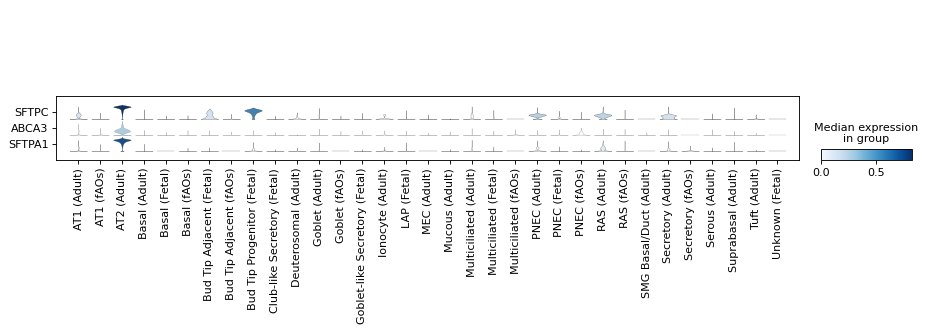

In [35]:
#AT2 Markers
AT2_markers=['SFTPC','ABCA3','SFTPA1']
sc.tl.score_genes(adata, AT2_markers, score_name='Alveolar Type 2_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,AT2_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

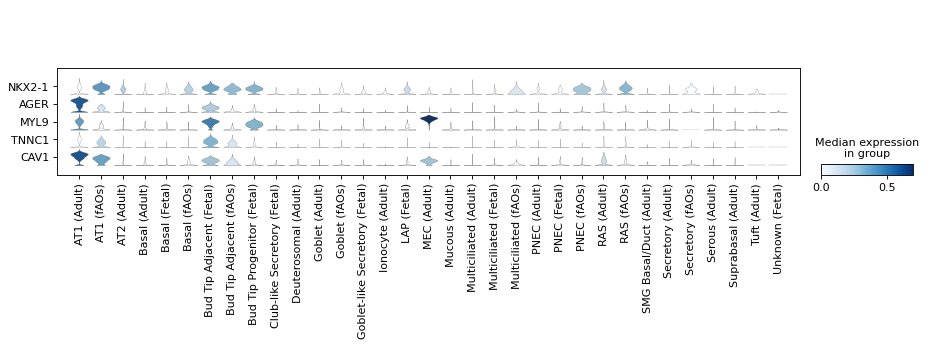

In [36]:
#Bud tip adjacent Markers
Bud_tip_adj_markers=['NKX2-1','AGER','MYL9','TNNC1','CAV1']
sc.tl.score_genes(adata, Bud_tip_adj_markers, score_name='Bud Tip Adjacent_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,Bud_tip_adj_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

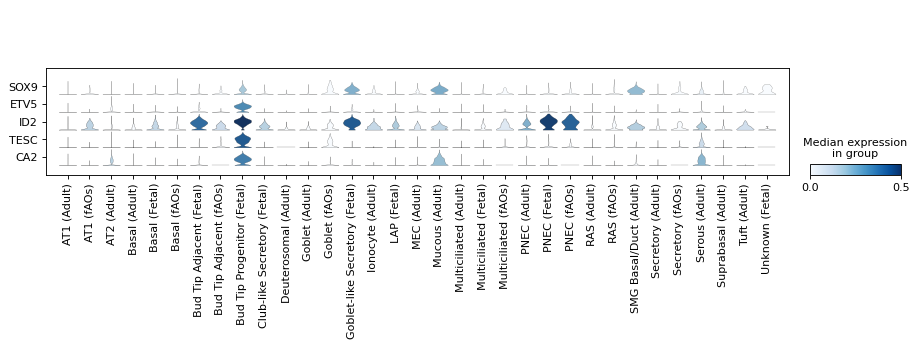

In [37]:
#Bud Tip Progenitors Markers
Bud_tip_progenitors_markers=['SOX9','ETV5','ID2','TESC','CA2']
sc.tl.score_genes(adata, Bud_tip_progenitors_markers, score_name='Bud Tip Progenitor_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,Bud_tip_progenitors_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

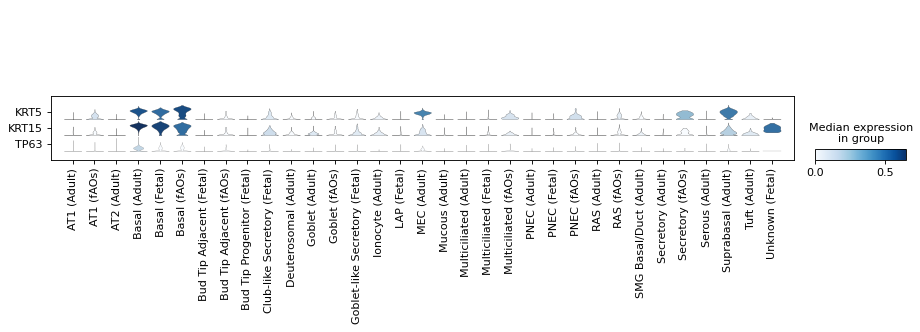

In [38]:
#Basal Markers
basal_markers=['KRT5','KRT15','TP63']
sc.tl.score_genes(adata, basal_markers, score_name='Basal_Signature',use_raw=True)
sc.pl.stacked_violin(adata,basal_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

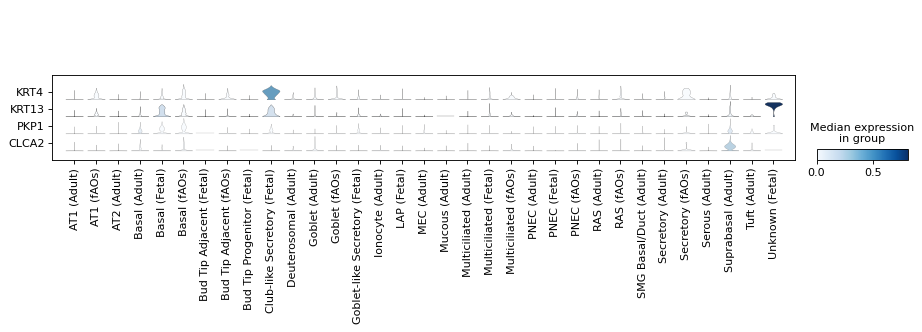

In [39]:
#SupraBasal Markers
suprabasal_markers=["KRT4","KRT13","PKP1", "CLCA2"]
sc.tl.score_genes(adata, suprabasal_markers, score_name='Suprabasal_Signature',use_raw=True)
sc.pl.stacked_violin(adata,suprabasal_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

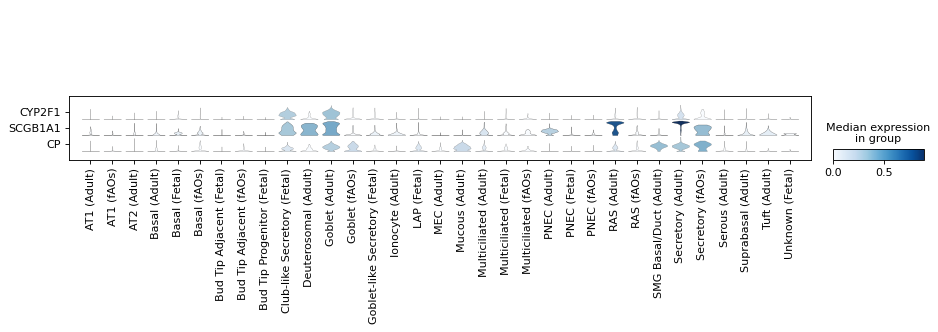

In [40]:
#Club Markers
club_markers=['CYP2F1','SCGB1A1','CP']
sc.tl.score_genes(adata, club_markers, score_name='Club_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,club_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

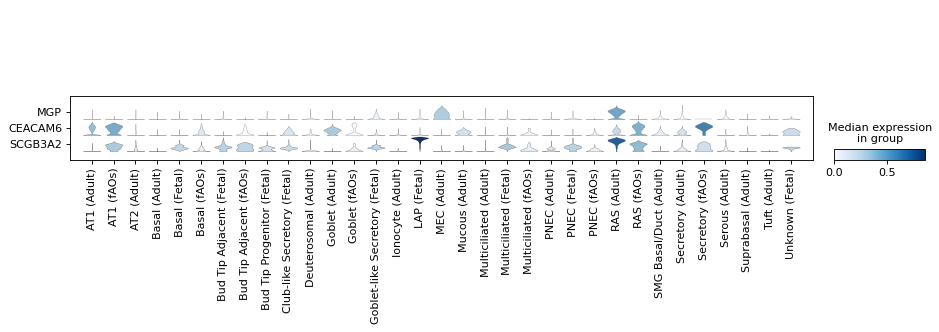

In [41]:
#RASC Markers
RASC_markers=['MGP','CEACAM6','SCGB3A2']
sc.tl.score_genes(adata, RASC_markers, score_name='Respiratory Airway Secretory_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,RASC_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

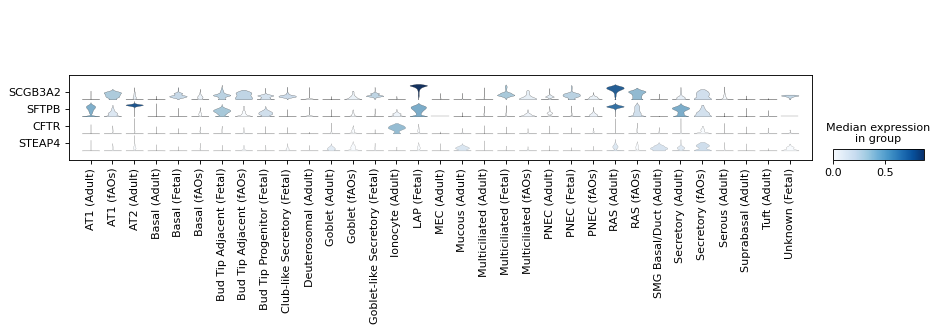

In [42]:
#LAP Markers
LAP_markers=['SCGB3A2','SFTPB','CFTR','STEAP4']
sc.tl.score_genes(adata, LAP_markers, score_name='Lower Airway Progenitor_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,LAP_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

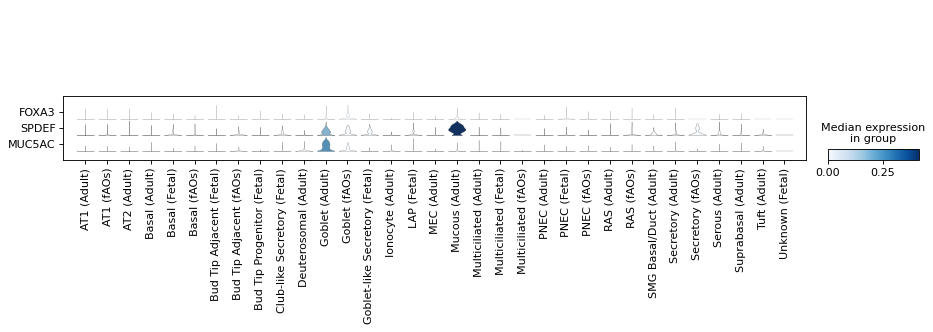

In [43]:
#Goblet Markers
goblet_markers=['FOXA3','SPDEF','MUC5AC'] 
sc.tl.score_genes(adata, goblet_markers, score_name='Goblet_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,goblet_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

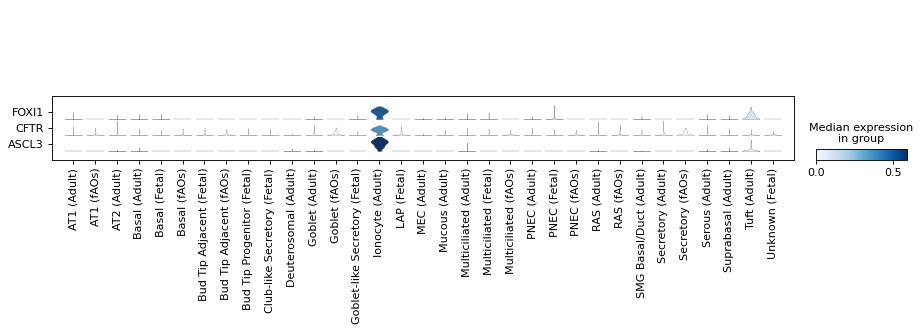

In [44]:
#Ionocyte Markers
ionocyte_markers=['FOXI1','CFTR','ASCL3']
sc.tl.score_genes(adata, ionocyte_markers, score_name='Ionocyte_Signature',use_raw=True)
sc.pl.stacked_violin(adata,ionocyte_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

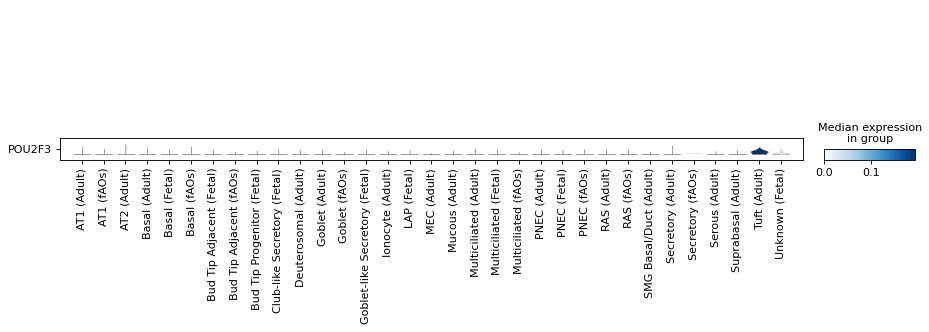

In [45]:
#Tuft Markers
tuft_markers=['POU2F3']
sc.tl.score_genes(adata, tuft_markers, score_name='Tuft_Signature',use_raw=True)
sc.pl.stacked_violin(adata,tuft_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

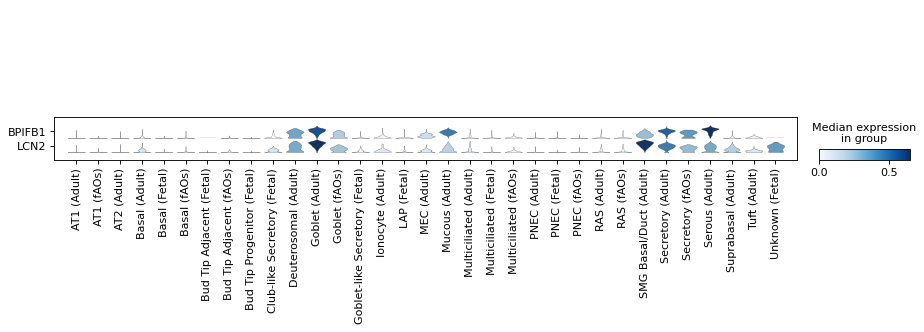

In [46]:
#Mucous Markers
mucous_markers=['BPIFB1','LCN2']
sc.tl.score_genes(adata, mucous_markers, score_name='Mucous_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,mucous_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

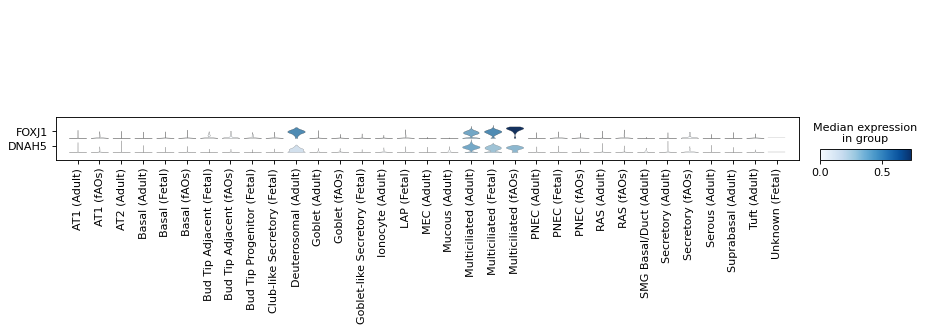

In [47]:
#Multiciliated Markers
multiciliated_markers=['FOXJ1','DNAH5']
sc.tl.score_genes(adata, multiciliated_markers, score_name='Multiciliated_Signature',use_raw=True)
sc.pl.stacked_violin(adata,multiciliated_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

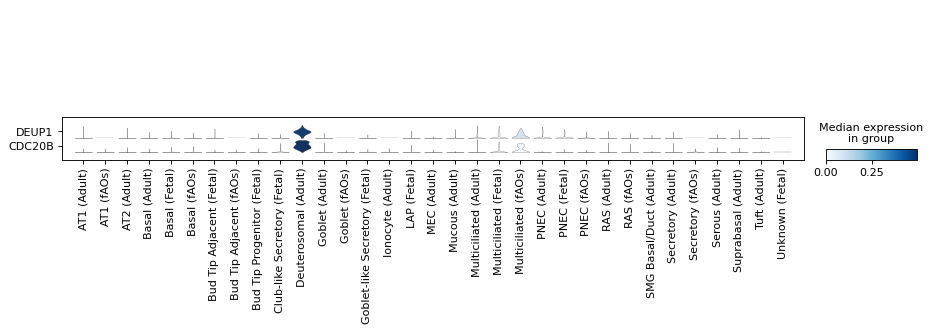

In [48]:
#Deuterosomal Markers
deuterosomal_markers=['DEUP1','CDC20B']
sc.tl.score_genes(adata, deuterosomal_markers, score_name='Deuterosomal_Signature',use_raw=True)
sc.pl.stacked_violin(adata,deuterosomal_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

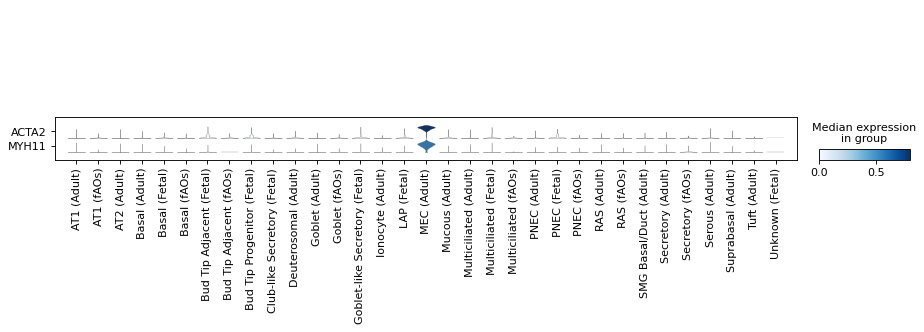

In [49]:
#MEC Markers
mec_markers=['ACTA2','MYH11']
sc.tl.score_genes(adata, mec_markers, score_name='Myoepithelial_Signature',use_raw=True)
sc.pl.stacked_violin(adata,mec_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

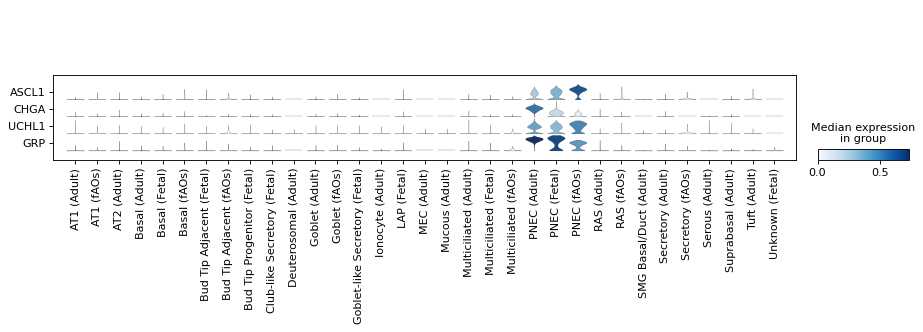

In [50]:
#Neuroendocrine Markers
NE_markers=['ASCL1','CHGA','UCHL1','GRP']
sc.tl.score_genes(adata, NE_markers, score_name='Neuroendocrine_Signature',use_raw=True)
sc.pl.stacked_violin(adata,NE_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

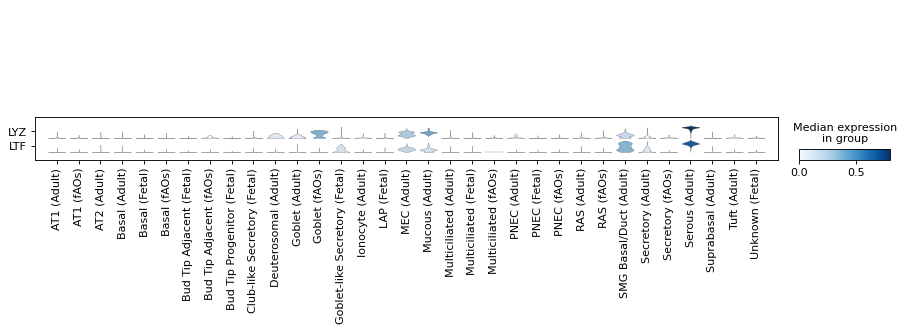

In [51]:
#Serous Markers
serous_markers=['LYZ','LTF']
sc.tl.score_genes(adata, serous_markers, score_name='Serous_Signature',use_raw=True) 
sc.pl.stacked_violin(adata,serous_markers,use_raw=True, groupby='CELL_TYPE_tissue',standard_scale='var',swap_axes=True)

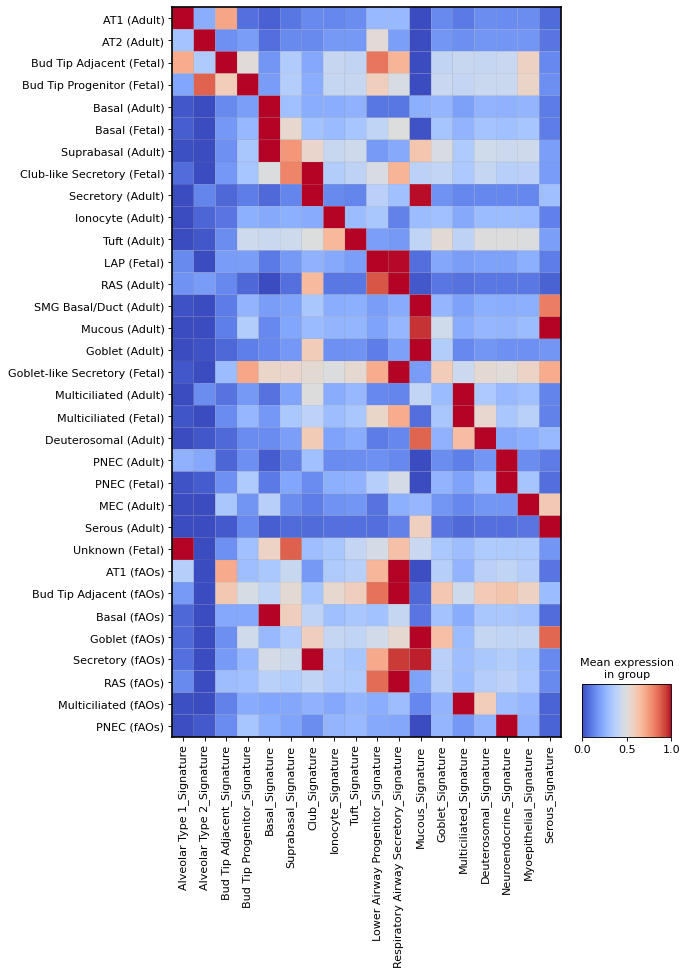

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

signatures = [
    'Alveolar Type 1_Signature','Alveolar Type 2_Signature','Bud Tip Adjacent_Signature','Bud Tip Progenitor_Signature',
    'Basal_Signature','Suprabasal_Signature','Club_Signature',
    'Ionocyte_Signature','Tuft_Signature','Lower Airway Progenitor_Signature','Respiratory Airway Secretory_Signature',
    'Mucous_Signature','Goblet_Signature','Multiciliated_Signature','Deuterosomal_Signature','Neuroendocrine_Signature',
    'Myoepithelial_Signature','Serous_Signature'
]

categories_order = [
    "AT1 (Adult)","AT2 (Adult)","Bud Tip Adjacent (Fetal)","Bud Tip Progenitor (Fetal)",
    "Basal (Adult)","Basal (Fetal)","Suprabasal (Adult)","Club-like Secretory (Fetal)","Secretory (Adult)",
    "Ionocyte (Adult)","Tuft (Adult)","LAP (Fetal)","RAS (Adult)",
    "SMG Basal/Duct (Adult)","Mucous (Adult)","Goblet (Adult)","Goblet-like Secretory (Fetal)",
    "Multiciliated (Adult)","Multiciliated (Fetal)","Deuterosomal (Adult)",
    "PNEC (Adult)","PNEC (Fetal)",
    "MEC (Adult)","Serous (Adult)","Unknown (Fetal)",
    'AT1 (fAOs)', 'Bud Tip Adjacent (fAOs)', 'Basal (fAOs)', 'Goblet (fAOs)',
    'Secretory (fAOs)', 'RAS (fAOs)', 'Multiciliated (fAOs)', 'PNEC (fAOs)'
]


# Create ordered category
adata.obs['CELL_TYPE_tissue'] = adata.obs['CELL_TYPE_tissue'].astype('category')
adata.obs['CELL_TYPE_tissue'] = adata.obs['CELL_TYPE_tissue'].cat.reorder_categories(
    categories_order, ordered=True
)

# MatrixPlot with row-wise (group-wise) scaling
sc.pl.matrixplot(
    adata,
    var_names=signatures,
    groupby='CELL_TYPE_tissue',
    standard_scale='group',     # normalize *per group / per row*
    cmap='coolwarm',
    dendrogram=False,
    figsize=(8, 12),
)

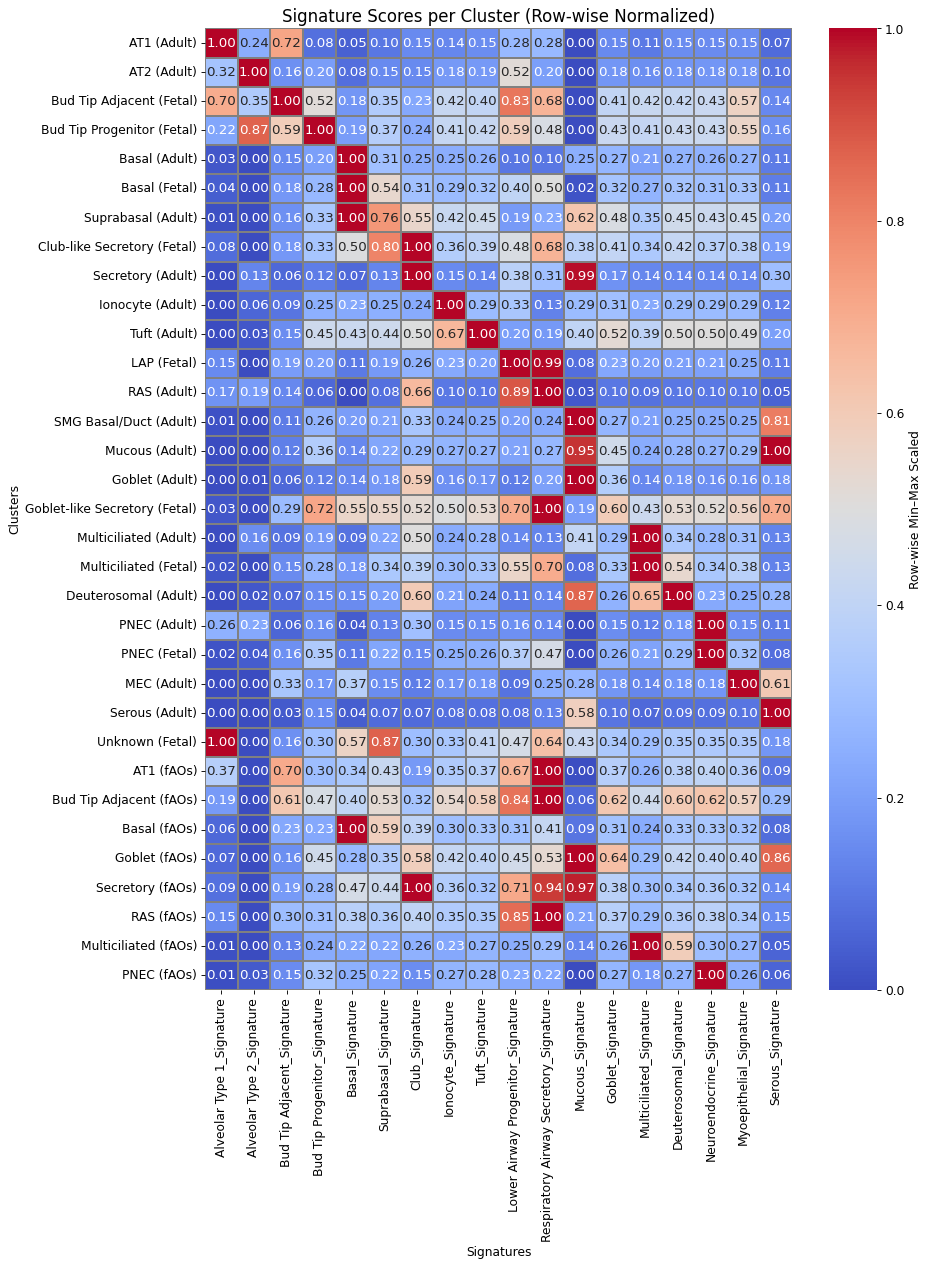

In [53]:
# Figure S3G

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

signatures = [
    'Alveolar Type 1_Signature','Alveolar Type 2_Signature','Bud Tip Adjacent_Signature','Bud Tip Progenitor_Signature',
    'Basal_Signature','Suprabasal_Signature','Club_Signature',
    'Ionocyte_Signature','Tuft_Signature','Lower Airway Progenitor_Signature','Respiratory Airway Secretory_Signature',
    'Mucous_Signature','Goblet_Signature','Multiciliated_Signature','Deuterosomal_Signature','Neuroendocrine_Signature',
    'Myoepithelial_Signature','Serous_Signature'
]

categories_order = [
    "AT1 (Adult)","AT2 (Adult)","Bud Tip Adjacent (Fetal)","Bud Tip Progenitor (Fetal)",
    "Basal (Adult)","Basal (Fetal)","Suprabasal (Adult)","Club-like Secretory (Fetal)","Secretory (Adult)",
    "Ionocyte (Adult)","Tuft (Adult)","LAP (Fetal)","RAS (Adult)",
    "SMG Basal/Duct (Adult)","Mucous (Adult)","Goblet (Adult)","Goblet-like Secretory (Fetal)",
    "Multiciliated (Adult)","Multiciliated (Fetal)","Deuterosomal (Adult)",
    "PNEC (Adult)","PNEC (Fetal)",
    "MEC (Adult)","Serous (Adult)","Unknown (Fetal)",
    'AT1 (fAOs)', 'Bud Tip Adjacent (fAOs)', 'Basal (fAOs)', 'Goblet (fAOs)',
    'Secretory (fAOs)', 'RAS (fAOs)', 'Multiciliated (fAOs)', 'PNEC (fAOs)'
]

# 1. Compute mean per group as before
df = adata.obs[signatures].copy()
df["CELL_TYPE_tissue"] = adata.obs["CELL_TYPE_tissue"]
group_means = df.groupby("CELL_TYPE_tissue").mean()

# 2. Subset to only categories you want to normalize within
subset = group_means.loc[categories_order]

# 3. ROW-WISE min–max normalization (scale per cluster)
subset_scaled = (subset - subset.min(axis=1)[:, None]) / (
    subset.max(axis=1) - subset.min(axis=1)
)[:, None]

# 4. Reorder
ordered = [cat for cat in categories_order if cat in subset_scaled.index]
scaled_group_means_ordered = subset_scaled.loc[ordered]

# Plot
plt.figure(figsize=(12, 16))

ax = sns.heatmap(
    scaled_group_means_ordered,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.4,
    linecolor='gray',
    cbar_kws={'label': 'Row-wise Min–Max Scaled'}
)

plt.title("Signature Scores per Cluster (Row-wise Normalized)", fontsize=15)
plt.xlabel("Signatures")
plt.ylabel("Clusters")
plt.tight_layout()
plt.savefig(os.path.join(figfolder, 'matrixplot_Alignment_Lung_Epithelium_celltype_signature_CELL_TYPE_tissue_values'),bbox_inches='tight')
plt.show()

In [54]:
annotation_dict = {
    "AT1 (fAOs)": "Transitional Distal progenitor-like",
    "Bud Tip Adjacent (fAOs)": "Transitional Distal progenitor-like",
    "Basal (fAOs)": "Basal",
    'Secretory (fAOs)': "Secretory",
    "RAS (fAOs)": "RAS/LAP",
    "Multiciliated (fAOs)": "Multiciliated",
    "Goblet (fAOs)": "Goblet",
    "PNEC (fAOs)": "PNEC",

 'AT1 (Adult)': 'AT1',
 'AT2 (Adult)': 'AT2',
 'Bud Tip Adjacent (Fetal)': 'Bud Tip Adjacent',
 'Bud Tip Progenitor (Fetal)': 'Bud Tip Progenitor',
 'Basal (Adult)': 'Basal',
 'Basal (Fetal)': 'Basal',
 'Suprabasal (Adult)': 'Suprabasal',
 'Club-like Secretory (Fetal)': 'Club-like Secretory',
 'Secretory (Adult)': 'Secretory',
 'Ionocyte (Adult)': 'Ionocyte',
 'Tuft (Adult)': 'Tuft',
 'LAP (Fetal)': 'LAP',
 'RAS (Adult)': 'RAS',
 'SMG Basal/Duct (Adult)': 'SMG Basal/Duct',
 'Mucous (Adult)': 'Mucous',
 'Goblet (Adult)': 'Goblet',
 'Goblet-like Secretory (Fetal)': 'Goblet-like Secretory',
 'Multiciliated (Adult)': 'Multiciliated',
 'Multiciliated (Fetal)': 'Multiciliated',
 'Deuterosomal (Adult)': 'Deuterosomal',
 'PNEC (Adult)': 'PNEC',
 'PNEC (Fetal)': 'PNEC',
 'MEC (Adult)': 'MEC',
 'Serous (Adult)': 'Serous',
 'Unknown (Fetal)': 'Unknown'
}

In [55]:
# Use the dictionary to rename cell types

adata.obs['CELL_TYPE'] = adata.obs['CELL_TYPE_tissue'].map(annotation_dict)
category_counts = adata.obs['CELL_TYPE'].value_counts()
sorted_categories = category_counts.index.to_list()
adata.obs['CELL_TYPE'] = pd.Categorical(adata.obs['CELL_TYPE'], categories=sorted_categories, ordered=True)
category_counts

AT2                                    59053
Suprabasal                             20167
Basal                                  16015
Multiciliated                          15426
AT1                                    12039
Serous                                  4333
RAS                                     4257
Goblet                                  2795
Secretory                               2762
LAP                                     2245
RAS/LAP                                 1994
PNEC                                    1940
Bud Tip Progenitor                      1776
Bud Tip Adjacent                        1626
Mucous                                  1113
SMG Basal/Duct                          1009
Club-like Secretory                      845
Goblet-like Secretory                    715
MEC                                      669
Transitional Distal progenitor-like      667
Deuterosomal                             202
Ionocyte                                 159
Tuft      

In [56]:
adata.write_h5ad('./../data/MergedDatasets/Merged_LungEpithelium_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# NEr-fAOs Cell type Annotation

In [4]:
adata_NEr_fAOs = sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata_NEr_fAOs

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

In [58]:
adata_NEr_fAOs.obs['CELL_TYPE']=adata.obs['CELL_TYPE']
adata_NEr_fAOs.obs['CELL_TYPE'] = adata_NEr_fAOs.obs['CELL_TYPE'].astype('category')
adata_NEr_fAOs.obs['CELL_TYPE'].cat.remove_unused_categories(inplace=True)

In [59]:
category_counts = adata_NEr_fAOs.obs['CELL_TYPE'].value_counts()
sorted_categories = category_counts.index.to_list()
adata_NEr_fAOs.obs['CELL_TYPE'] = pd.Categorical(adata_NEr_fAOs.obs['CELL_TYPE'], categories=sorted_categories, ordered=True)
sorted_categories

['Basal',
 'RAS/LAP',
 'Transitional Distal progenitor-like',
 'PNEC',
 'Goblet',
 'Secretory',
 'Multiciliated']

In [60]:
category_counts = adata_NEr_fAOs.obs['CELL_TYPE'].value_counts()
category_counts

Basal                                  2019
RAS/LAP                                1994
Transitional Distal progenitor-like     667
PNEC                                    363
Goblet                                  274
Secretory                                63
Multiciliated                            61
Name: CELL_TYPE, dtype: int64

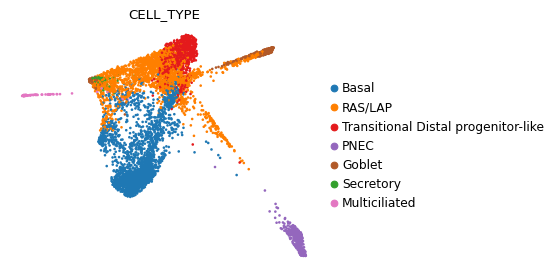

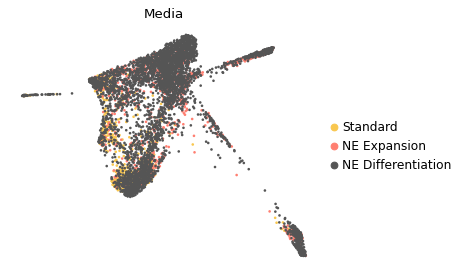

In [61]:
adata_NEr_fAOs.uns['CELL_TYPE_colors']=[
    '#1f78b4',  # Basal
    '#ff7f00',  # RAS/LAP
    '#e41a1c',  # Transitional Distal progenitor-like
    '#9467bd',  # PNEC
    '#b15928',  # Goblet
    '#33a02c',  # Secretory
    '#e377c2',  # Multiciliated
]
sc.pl.draw_graph(adata_NEr_fAOs,use_raw=True, color=['CELL_TYPE'],save='_Std_NE_Exp_Diff_CELLTYPE')
sc.pl.draw_graph(adata_NEr_fAOs,use_raw=True, color=['Media'])

# Figure 3F

In [62]:
#adata.uns['log1p']['base']= None
sc.tl.rank_genes_groups(adata_NEr_fAOs,'CELL_TYPE',method='wilcoxon',key_added='CELL_TYPE_markers')

In [63]:
#adata.uns['log1p']['base']= None
sc.tl.filter_rank_genes_groups(adata_NEr_fAOs,key='CELL_TYPE_markers',
                        key_added='CELL_TYPE_markers_filtered',
                        min_fold_change=1,min_in_group_fraction=0.5,max_out_group_fraction=0.75)

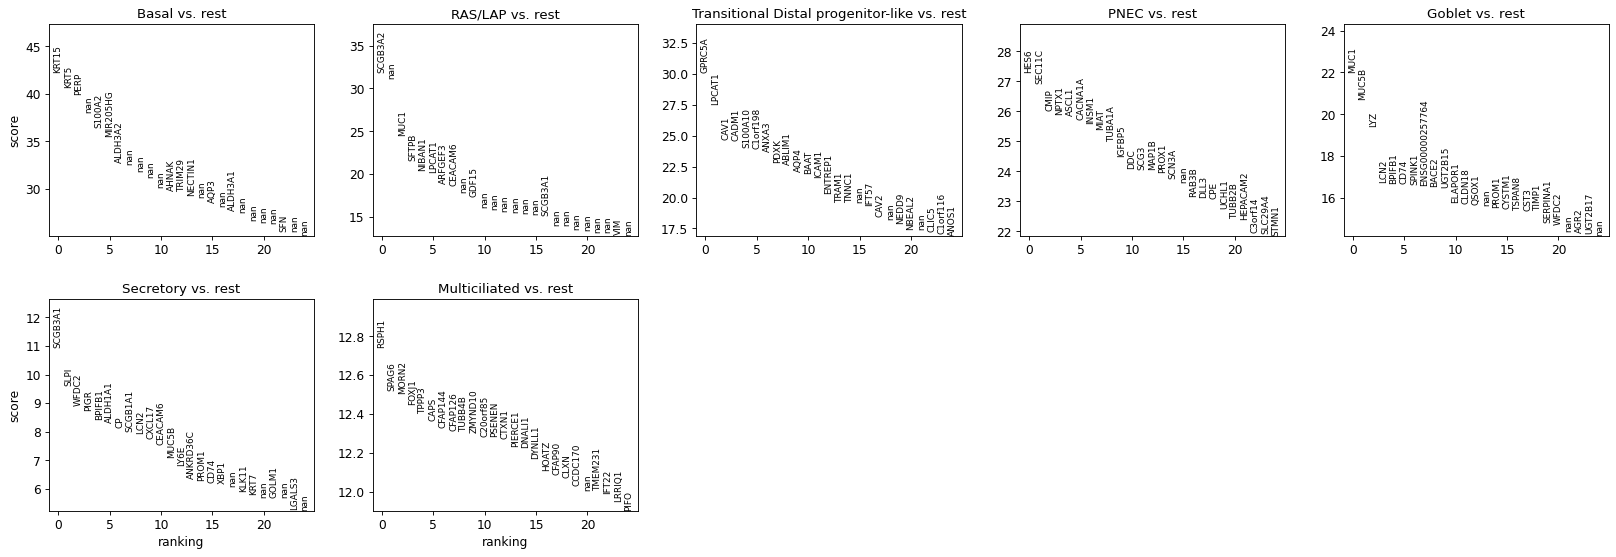

In [64]:
sc.pl.rank_genes_groups(adata_NEr_fAOs, n_genes=25, sharey=False,key='CELL_TYPE_markers_filtered',ncols=5,save='_Std_NE_Exp_Diff_CELL_TYPE_markers')

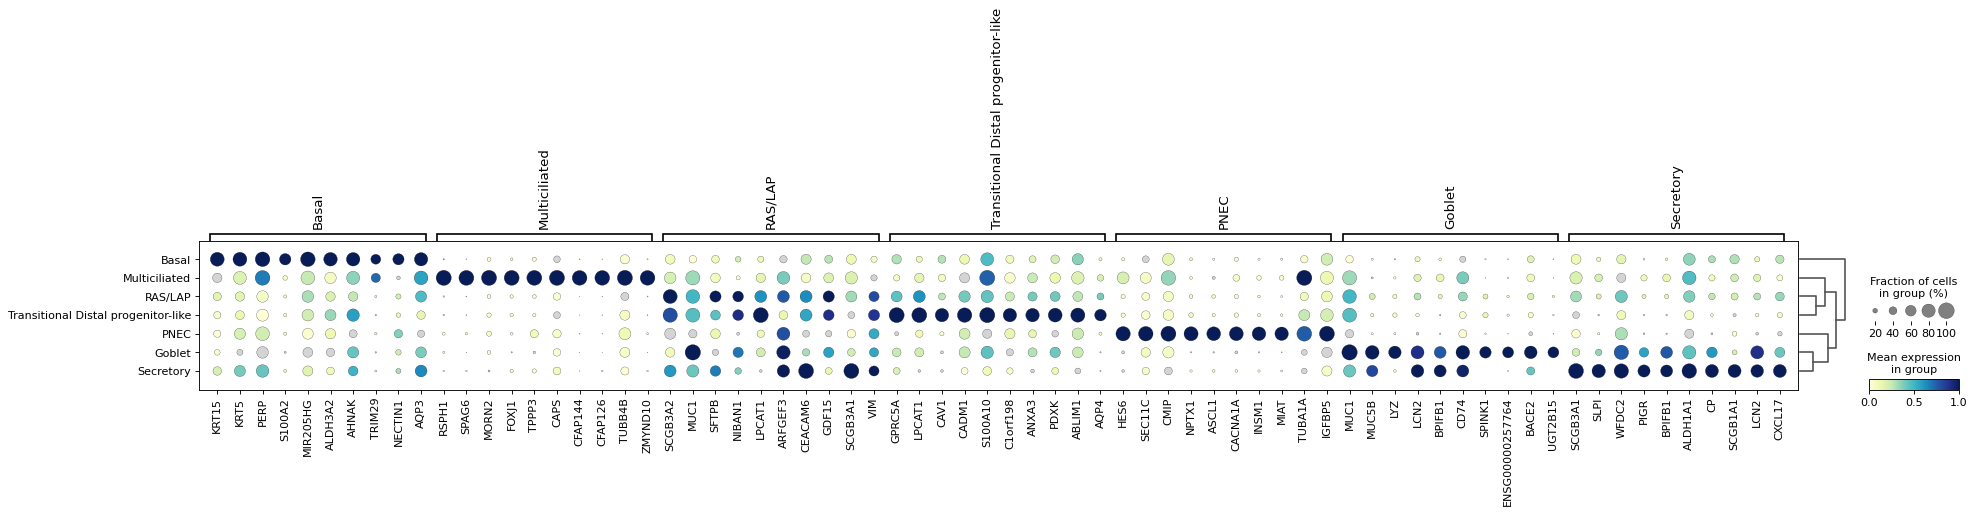

In [65]:
## Figure 3F
sc.tl.dendrogram(adata_NEr_fAOs,'CELL_TYPE', n_pcs=30)
sc.pl.rank_genes_groups_dotplot(adata_NEr_fAOs,n_genes=10,key='CELL_TYPE_markers_filtered',cmap=cmap,standard_scale='var',
                                min_logfoldchange=1,vmin=0,save='_Std_NE_Exp_Diff_CELL_TYPE_markers')
del adata_NEr_fAOs.uns['CELL_TYPE_markers_filtered']

In [66]:
adata_NEr_fAOs.write_h5ad('./../data/NEr_fAOs_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## Figure 3E

In [4]:
adata_NEr_fAOs = sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata_NEr_fAOs

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

In [5]:
column_0 = adata_NEr_fAOs.obs['CELL_TYPE']
column_1 = adata_NEr_fAOs.obs['Media']
column_2 = adata_NEr_fAOs.obs['Patient ID']
column_3 = adata_NEr_fAOs.obs['Time point'].astype(str)

# Create a DataFrame using the extracted columns
df = pd.DataFrame({'Cell type': column_0,
                   'Media': column_1,
                   'Patient ID': column_2,
                  'Time point':column_3})
df

Cell type               Media Patient ID Time point
s003.1            Basal            Standard       124e   day0-std
s003.2    Multiciliated            Standard       124e   day0-std
s003.3            Basal            Standard       124e   day0-std
s003.4            Basal            Standard       124e   day0-std
s003.5            Basal            Standard       124e   day0-std
...                 ...                 ...        ...        ...
s007.152          Basal  NE Differentiation       125e      day10
s007.154        RAS/LAP  NE Differentiation       125e      day10
s007.155        RAS/LAP  NE Differentiation       125e      day10
s007.156          Basal  NE Differentiation       125e      day10
s007.157          Basal  NE Differentiation       125e      day10

[5441 rows x 4 columns]

In [6]:
# Group by and calculate the percentage of each category
grouped_df = df.groupby('Media')['Cell type'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Media')
order = ['Standard','NE Expansion','NE Differentiation']
grouped_df = grouped_df.loc[order]
grouped_df

Cell type               Basal    RAS/LAP  Transitional Distal progenitor-like  \
Media                                                                           
Standard            79.556260  12.995246                             0.475436   
NE Expansion        25.534442  48.337292                             8.076010   
NE Differentiation  32.812500  37.928427                            15.020161   

Cell type               PNEC     Goblet  Secretory  Multiciliated  
Media                                                              
Standard            0.950872   2.060222   2.535658       1.426307  
NE Expansion        5.225653  10.926366   1.543943       0.356295  
NE Differentiation  7.888105   4.259073   0.856855       1.234879

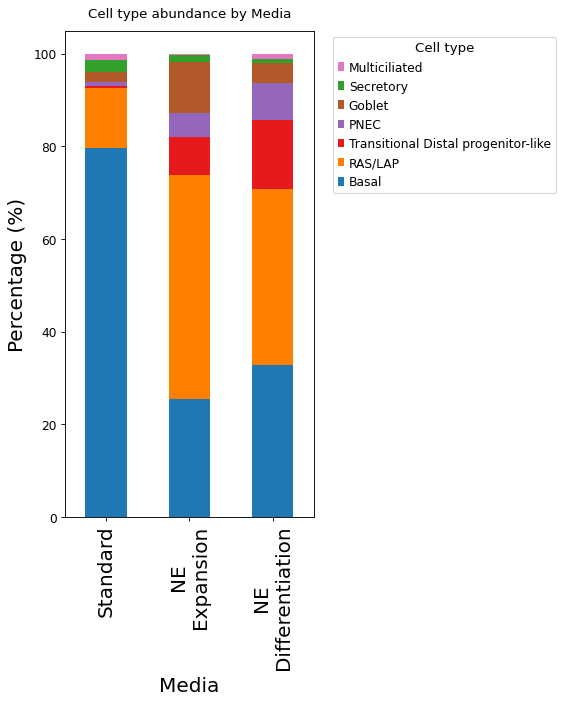

In [8]:
fig, ax = plt.subplots(figsize=(4, 8))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Media')['Cell type'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Media')
order = ['Standard','NE Expansion','NE Differentiation']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata_NEr_fAOs.uns['CELL_TYPE_colors'],ax=ax)

# Customize the plot
plt.title('Cell type abundance by Media',pad=12)
plt.xlabel('Media',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=90,size=18)
ax.set_xticklabels([label.replace(' ', '\n') for label in grouped_df.index], size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(os.path.join(figfolder,'StackedPlot_fAOs_media_celltype'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

In [9]:
grouped_df = df.groupby('Time point')['Cell type'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0-std','day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]
grouped_df

Cell type       Basal    RAS/LAP  Transitional Distal progenitor-like  \
Time point                                                              
day0-std    79.556260  12.995246                             0.475436   
day0        25.534442  48.337292                             8.076010   
day1        25.628492  44.134078                            15.223464   
day3        36.284470  39.332366                            12.699565   
day10       37.564767  28.583765                            17.530225   

Cell type        PNEC     Goblet  Secretory  Multiciliated  
Time point                                                  
day0-std     0.950872   2.060222   2.535658       1.426307  
day0         5.225653  10.926366   1.543943       0.356295  
day1         4.469274   9.357542   0.837989       0.349162  
day3         7.910015   1.669086   1.088534       1.015965  
day10       12.089810   1.036269   0.604491       2.590674

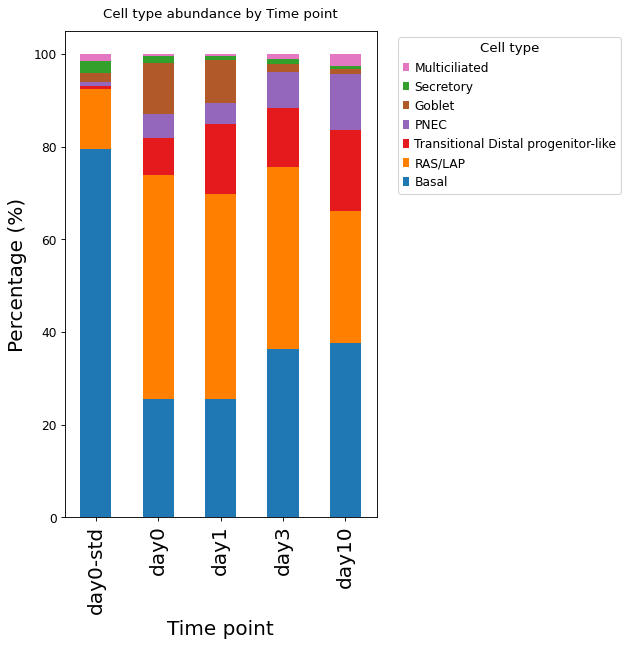

In [10]:
## Figure 3E

fig, ax = plt.subplots(figsize=(5, 8))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Time point')['Cell type'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0-std','day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata_NEr_fAOs.uns['CELL_TYPE_colors'],ax=ax)

# Customize the plot
plt.title('Cell type abundance by Time point',pad=12)
plt.xlabel('Time point',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=90,size=18)
ax.set_xticklabels([label.replace(' ', '\n') for label in grouped_df.index], size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(os.path.join(figfolder,'StackedPlot_fAOs_media_timepoint_celltype'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# Figure S3H

In [7]:
grouped_dfs = {}

order = ['day0-std', 'day0', 'day1', 'day3', 'day10']

for patient in df['Patient ID'].unique():
    grouped_df = (
        df[df['Patient ID'] == patient]
        .groupby('Time point')['Cell type']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        * 100
    )

    grouped_df = (
        grouped_df
        .reset_index()
        .set_index('Time point')
        .reindex(order)
    )

    grouped_dfs[patient] = grouped_df

for patient, gdf in grouped_dfs.items():
    print(patient)
    display(gdf)

124e

Cell type       Basal    RAS/LAP  Transitional Distal progenitor-like  \
Time point                                                              
day0-std    70.261438  18.954248                             0.326797   
day0         7.666667  53.666667                             9.666667   
day1         7.915058  43.629344                            24.324324   
day3        28.919861  45.644599                            11.498258   
day10       30.107527  32.473118                            14.193548   

Cell type        PNEC     Goblet  Secretory  Multiciliated  
Time point                                                  
day0-std     0.000000   3.594771   3.921569       2.941176  
day0         4.333333  24.666667   0.000000       0.000000  
day1         2.895753  21.235521   0.000000       0.000000  
day3         9.756098   3.135889   0.348432       0.696864  
day10       15.698925   2.365591   1.075269       4.086022

125e

Cell type       Basal    RAS/LAP  Transitional Distal progenitor-like  \
Time point                                                              
day0-std    88.307692   7.384615                             0.615385   
day0        41.237113  45.360825                             7.216495   
day1        27.925532  44.414894                            19.946809   
day3        30.696203  37.974684                            20.886076   
day10       30.508475  26.779661                            34.915254   

Cell type       PNEC    Goblet  Secretory  Multiciliated  
Time point                                                
day0-std    1.846154  0.615385   1.230769       0.000000  
day0        1.374570  2.061856   1.718213       1.030928  
day1        6.914894  0.531915   0.000000       0.265957  
day3        8.702532  0.316456   0.316456       1.107595  
day10       7.457627  0.000000   0.000000       0.338983

119e

Cell type       Basal    RAS/LAP  Transitional Distal progenitor-like  \
Time point                                                              
day0-std          NaN        NaN                                  NaN   
day0        28.685259  45.418327                             7.171315   
day1        41.078067  44.423792                             3.159851   
day3        48.583878  37.254902                             2.178649   
day10       51.507538  25.376884                             8.542714   

Cell type        PNEC    Goblet  Secretory  Multiciliated  
Time point                                                 
day0-std          NaN       NaN        NaN            NaN  
day0        10.756972  4.780876   3.187251       0.000000  
day1         4.275093  4.089219   2.230483       0.743494  
day3         5.664488  2.614379   2.614379       1.089325  
day10       11.306533  0.251256   0.502513       2.512563

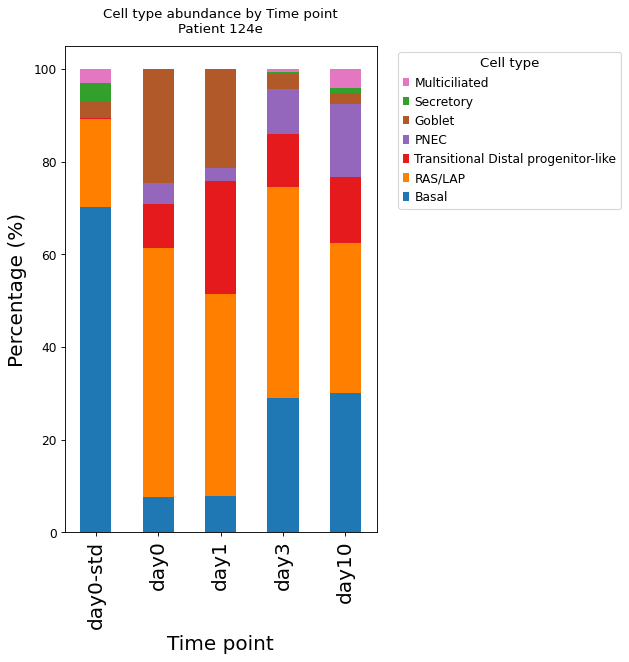

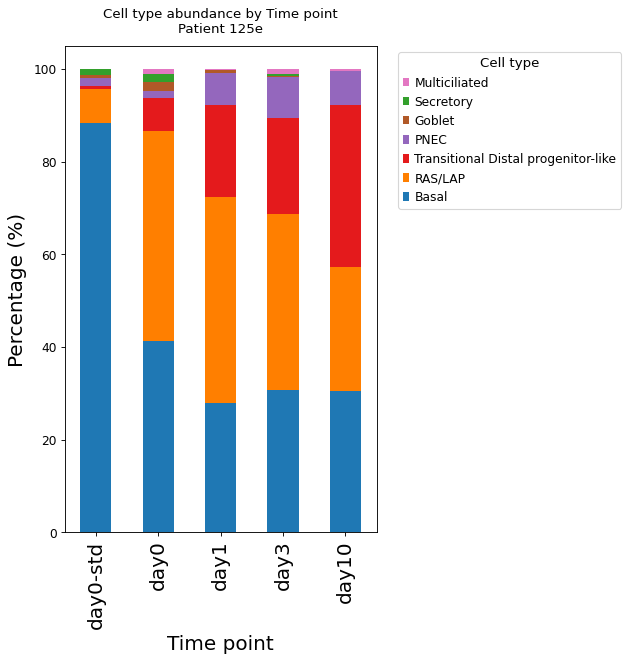

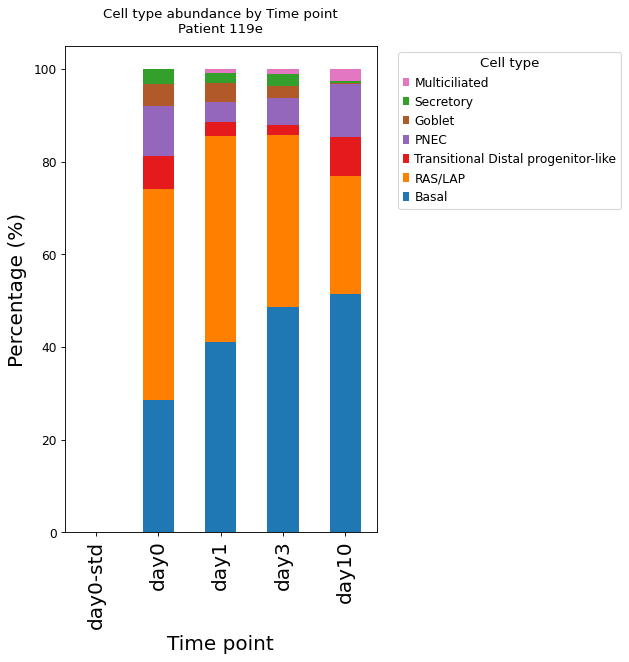

In [9]:
## Figure S3H

order = ['day0-std', 'day0', 'day1', 'day3', 'day10']

for patient, grouped_df in grouped_dfs.items():

    fig, ax = plt.subplots(figsize=(5, 8))

    # Ensure correct order
    grouped_df = grouped_df.reindex(order)

    # Plot
    grouped_df.plot(
        kind='bar',
        stacked=True,
        alpha=1,
        color=adata_NEr_fAOs.uns['CELL_TYPE_colors'],
        ax=ax
    )

    # Customize
    ax.set_title(f'Cell type abundance by Time point\nPatient {patient}', pad=12)
    ax.set_xlabel('Time point', size=18, labelpad=6)
    ax.set_ylabel('Percentage (%)', size=18, labelpad=6)
    ax.set_xticklabels(
        [label.replace(' ', '\n') for label in grouped_df.index],
        rotation=90,
        size=18
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        title='Cell type',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    # Save figure
    outfile = os.path.join(
        figfolder,
        f'StackedPlot_fAOs_{patient}_timepoint_celltype'
    )
    plt.savefig(outfile, bbox_inches='tight', pad_inches=0.1)

    plt.show()
    plt.close(fig)
